In [1]:
%pip install scipy --upgrade
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.optimize as opt
import numpy as np
import pandas as pd
import statsmodels as sm
%pip install pymoo
import pymoo as pymoo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 11.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 6.5 

In [2]:
1.5/(1.5+1.8)

0.4545454545454546

In [3]:
stats.norm.ppf(0.454,80,10)

78.84438402894617

In [4]:
stats.norm.cdf(78.845,80,10)

0.4540244102386926

# **Snowboards Quantity(Q) Decisions**

## **Myerson Distribution**
Below is a function that simulates random samples from the Myerson distribution in section 4.4 of Roger Myerson's 2005 book.
This is a generalized version of normal & lognormal distribution.


In [5]:
# https://www.solver.com/risk-solver-help/psi-function-help/simulation/distributions/psimyerson
# https://en.wikipedia.org/wiki/Roger_Myerson

def randomMyerson(n,q1,q2,q3,lower=-1*math.inf,upper=math.inf,tl=0.5):
   #n: the number of random samples
   #q1: xx percentile, xx<50 & usually xx=25
   #q2: 50 percentile
   #q3: xx percentile, xx>50 & usually xx=75
   #lower: minimum possible value
   #upper: maximum possible value
   #tl: tail probability = P(X<q1)+P(X>q3)
   ######################################
   x=np.random.uniform(0,1,n)
   id=np.where(x>0.999999)
   x[id]=0.999999
   id=np.where(x<0.000001)
   x[id]=0.000001
   #Above avoids sampling values that are too extreme
   norml=stats.norm.ppf(x)/stats.norm.ppf(1-tl/2)
   br=(q3-q2)/(q2-q1)
   if br==1:
     res=q2+(q3-q2)*norml
   else:
     res=q2+(q3-q2)*(br**norml-1)/(br-1)
   #
   #Below is R code operations
   #pmin(pmax(res, lower), upper)
   #
   id=np.where(res<lower)
   res[id]=lower
   id=np.where(res>upper)
   res[id]=upper
   return res

In [6]:
#P(weather is cold)
pcold=1/3
#Demand parameters
q1normal=60000
q2normal=75000
q3normal=90000

q1cold=80000
q2cold=100000
q3cold=125000

#Cost parameters
unitcost=20
unitprice=48
salvage=8

#q as the order quantity. Try different ordering decisions
qval=np.arange(50000,150001,1000)

#Number of simulation runs
S=10000


In [7]:
#Simulate random demand
#1: cold; 0:normal
weather=np.random.choice([1,0],S,replace=True,p=[pcold,1-pcold])

demand=np.empty(S)
for s in range(0,S):
  #1: cold; 0:normal
  if weather[s]==1:
    demand[s]=randomMyerson(1,q1cold,q2cold,q3cold,lower=0)
  else:
    demand[s]=randomMyerson(1,q1normal,q2normal,q3normal,lower=0)
  demand[s]=np.round(demand[s],0)

<ipython-input-7-10575ae3dff7>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  demand[s]=randomMyerson(1,q1normal,q2normal,q3normal,lower=0)
<ipython-input-7-10575ae3dff7>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  demand[s]=randomMyerson(1,q1cold,q2cold,q3cold,lower=0)


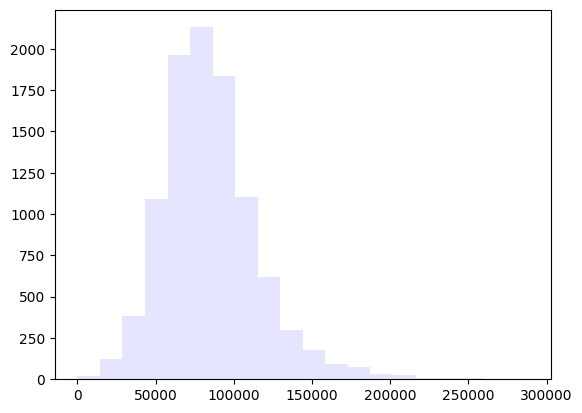

In [8]:
plt.hist(demand,bins=20,alpha=0.1,color='blue')
plt.show()

In [9]:
def profit(d,q=80000):
  #d: demand realizations
  if type(d)==int:
    d=[d]
  d=np.array(d)
  profitval=np.empty(len(d))
  for i in range(0,len(d)):
    profitval[i]=(unitprice-unitcost)*min(q,d[i])+(salvage-unitcost)*max(q-d[i],0)
  return profitval

In [10]:
profit(d=[90000,80000],q=80000)

array([2240000., 2240000.])

In [11]:
profit(d=70000,q=80000)

array([1840000.])

In [12]:
qval

array([ 50000,  51000,  52000,  53000,  54000,  55000,  56000,  57000,
        58000,  59000,  60000,  61000,  62000,  63000,  64000,  65000,
        66000,  67000,  68000,  69000,  70000,  71000,  72000,  73000,
        74000,  75000,  76000,  77000,  78000,  79000,  80000,  81000,
        82000,  83000,  84000,  85000,  86000,  87000,  88000,  89000,
        90000,  91000,  92000,  93000,  94000,  95000,  96000,  97000,
        98000,  99000, 100000, 101000, 102000, 103000, 104000, 105000,
       106000, 107000, 108000, 109000, 110000, 111000, 112000, 113000,
       114000, 115000, 116000, 117000, 118000, 119000, 120000, 121000,
       122000, 123000, 124000, 125000, 126000, 127000, 128000, 129000,
       130000, 131000, 132000, 133000, 134000, 135000, 136000, 137000,
       138000, 139000, 140000, 141000, 142000, 143000, 144000, 145000,
       146000, 147000, 148000, 149000, 150000])

In [13]:
simprofit=np.empty([S,len(qval)])
avgprofit=np.empty(len(qval))
sdprofit=np.empty(len(qval))

for i in range(0,len(qval)):
  simprofit[:,i]=profit(d=demand,q=qval[i])
  avgprofit[i]=np.mean(simprofit[:,i])
  sdprofit[i]=np.std(simprofit[:,i])

Text(0, 0.5, 'E[Profit]')

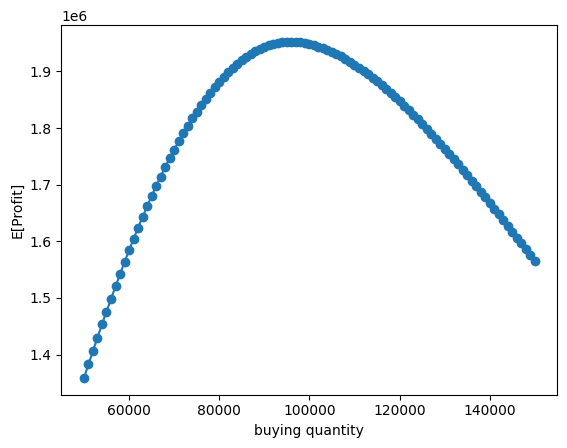

In [14]:
plt.figure()
plt.plot(qval,avgprofit, marker='o')
plt.xlabel("buying quantity")
plt.ylabel("E[Profit]")

Text(0, 0.5, 'E[Profit]')

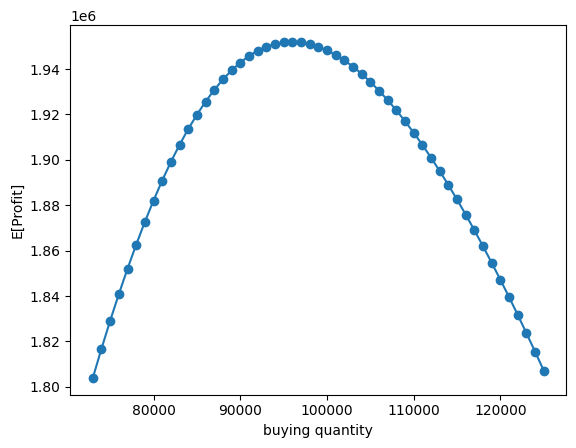

In [15]:
plt.figure()
plt.plot(qval[np.where(avgprofit>1800000)],avgprofit[np.where(avgprofit>1800000)], marker='o')
plt.xlabel("buying quantity")
plt.ylabel("E[Profit]")

In [16]:
qval[np.argmax(avgprofit)]

96000

In [17]:
cu=unitprice-unitcost
co=unitcost-salvage
cu
co
#Calculate the critical fractile
frac=cu/(cu+co)
frac

qstar=np.quantile(demand,frac)
qstar=round(qstar,0)
print(qstar)

95925.0


## **Assess the value of perfect information about cold or normal**

In [18]:
cu=unitprice-unitcost
co=unitcost-salvage
cu
co
#Calculate the critical fractile
frac=cu/(cu+co)
frac

dcold=randomMyerson(S,q1cold,q2cold,q3cold,lower=0)
qcold=np.quantile(dcold,frac)
qcold=round(qcold,0)


dnormal=randomMyerson(S,q1normal,q2normal,q3normal,lower=0)
qnormal=np.quantile(dnormal,frac)
qnormal=round(qnormal,0)

print(qcold)
print(qnormal)
print(qcold*(pcold)+qnormal*(1-pcold))

118875.0
86888.0
97550.33333333334


In [19]:
print(avgprofit[np.where(qval==118000)])
print(avgprofit[np.where(qval==87000)])
print(avgprofit[np.where(qval==96000)])
print(avgprofit[np.where(qval==97000)])

[1861918.932]
[1930813.54]
[1951974.908]
[1951721.764]


In [20]:
profit_perfectinfo=np.empty(S)

for s in range(0,S):
  #1: cold; 0:weather
  if weather[s]==1:
    q=qcold
  else:
    q=qnormal
  #
  profit_perfectinfo[s]=(unitprice-unitcost)*min(q,demand[s])+(salvage-unitcost)*max(q-demand[s],0)


In [21]:
print(max(avgprofit))
print(np.mean(profit_perfectinfo))

#Value of information
print(np.mean(profit_perfectinfo)-max(avgprofit))

1951974.908
2005719.3656
53744.45759999985


# **Airline Price(P) & Quantity(Q) Decisions**

In [22]:
np.random.seed(5566)

b0=600
b1=-5
#Define a demand function first
def Demand(Price, b0=600, b1=-5):
  Dval=b0+b1*Price+np.random.normal(0,10,1)
  Dval=np.round(Dval)
  return max(Dval,0)

Demand(100)

array([96.])

In [23]:
Demand(100)

array([94.])

In [24]:
#Derive the parameters of no-show distribution
mu_noshow=0.1
sd_noshow=0.025

def beta_params(x):
  f=[x[0]/(x[0]+x[1])-mu_noshow,
   (x[0]*x[1])/((x[0]+x[1])**2*(x[0]+x[1]+1))-sd_noshow**2]
  return f

print(beta_params([1,1]))
print(beta_params([2,1]))

sol=opt.root(beta_params,[15,15])

a_est=sol.x[0]
b_est=sol.x[1]

sol.x

[0.4, 0.08270833333333333]
[0.5666666666666667, 0.05493055555555555]


array([ 14.3, 128.7])

In [25]:
print(beta_params([14.3,128.7]))

[0.0, -2.168404344971009e-19]


In [26]:
#Define a performance function
fixedC=12000
capacity=150
refund=0.5
penalty=2.5
S=1000

noshowfrac=np.random.beta(a_est,b_est,S)

def Perf(P, Q):
  profit=np.empty(S)
  sold=np.empty(S)
  show=np.empty(S)
  board=np.empty(S)
  bumped=np.empty(S)
  empty=np.empty(S)
  for s in range(S):
    demand_s=Demand(P)
    sold[s]=min(demand_s,Q)
    noshowfrac_s=noshowfrac[s]
    show[s]=round(sold[s]*(1-noshowfrac_s))
    board[s]=min(show[s],capacity)
    bumped[s]=show[s]-board[s]
    empty[s]=max(0,capacity-board[s])
    profit[s]=P*sold[s]-(sold[s]-show[s])*P*refund-bumped[s]*P*penalty-fixedC
    #print([profit[s],sold[s],show[s],board[s],bumped[s],empty[s]])
  avgprofit=np.mean(profit)
  avgboard=np.mean(board)
  SL=np.count_nonzero(bumped==0)/S
  return [avgprofit, avgboard, SL]

print(Perf(90,150))
print(Perf(100,151))


[494.07, 131.473, 1.0]
[-2451.45, 90.443, 1.0]


<ipython-input-26-ed2ba54bffbf>:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sold[s]=min(demand_s,Q)


In [27]:
#Perform numerical optimization
def Perf(x):
  #resetting the seed is important!
  np.random.seed(5566)
  P=x[0]
  Q=x[1]
  profit=np.empty(S)
  sold=np.empty(S)
  show=np.empty(S)
  board=np.empty(S)
  bumped=np.empty(S)
  empty=np.empty(S)
  for s in range(S):
    demand_s=Demand(P)
    sold[s]=min(demand_s,Q)
    noshowfrac_s=noshowfrac[s]
    show[s]=round(sold[s]*(1-noshowfrac_s))
    board[s]=min(show[s],capacity)
    bumped[s]=show[s]-board[s]
    empty[s]=max(0,capacity-board[s])
    profit[s]=P*sold[s]-(sold[s]-show[s])*P*refund-bumped[s]*P*penalty-fixedC
    #print([profit[s],sold[s],show[s],board[s],bumped[s],empty[s]])
  avgprofit=np.mean(profit)
  avgboard=np.mean(board)
  SL=np.count_nonzero(bumped==0)/S
  return -1*avgprofit


In [28]:
Perf([90,154])

<ipython-input-27-3dac94ad1545>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sold[s]=min(demand_s,Q)


-632.04

In [29]:
##Use Pymoo for numerical optimization
## https://pymoo.org/index.html

##Define the optimization problem first
from pymoo.problems.functional import FunctionalProblem

problem=FunctionalProblem(n_var=2,objs=Perf,xl=np.array([80,150]),xu=np.array([100,180]))
problem.evaluate(np.array([90,150]))

<ipython-input-27-3dac94ad1545>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sold[s]=min(demand_s,Q)


array([-484.395])

In [30]:
##Hooke-Jeeves Search
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.optimize import minimize

resHK=minimize(problem,algorithm=PatternSearch(),verbose=True)

<ipython-input-27-3dac94ad1545>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sold[s]=min(demand_s,Q)


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       20 |  5.823292E+01 | -1.127694E+03
     2 |       24 | -1.127694E+03 | -1.127694E+03
     3 |       28 | -1.163278E+03 | -1.198862E+03
     4 |       33 | -1.198862E+03 | -1.198862E+03
     5 |       37 | -1.198862E+03 | -1.198862E+03
     6 |       40 | -1.198886E+03 | -1.198910E+03
     7 |       45 | -1.198910E+03 | -1.198910E+03
     8 |       49 | -1.199438E+03 | -1.199967E+03
     9 |       54 | -1.199967E+03 | -1.199967E+03
    10 |       58 | -1.200103E+03 | -1.200238E+03
    11 |       63 | -1.200238E+03 | -1.200238E+03
    12 |       67 | -1.200279E+03 | -1.200321E+03
    13 |       72 | -1.200240E+03 | -1.200321E+03
    14 |       76 | -1.200743E+03 | -1.201166E+03
    15 |       79 | -1.200717E+03 | -1.201166E+03
    16 |       82 | -1.201213E+03 | -1.201259E+03
    17 |       87 | -1.201259E+03 | -1.201259E+03
    18 |       90 | -1.201331E+03 | -1.201403E+03
    19 |       95 | -1.201403E+03 | -1.201403E+03


In [31]:
print("Best solution found: \nX = %s\nF = %s" % (resHK.X, resHK.F))

Best solution found: 
X = [ 86.79011646 165.12180854]
F = [-1201.49330907]


In [32]:
##Nelder-Mead Search
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
resNM=minimize(problem,algorithm=NelderMead(),verbose=True)

<ipython-input-27-3dac94ad1545>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sold[s]=min(demand_s,Q)


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       20 |  5.823292E+01 | -1.127694E+03
     2 |       22 | -1.079113E+03 | -1.127694E+03
     3 |       23 | -1.039587E+03 | -1.127694E+03
     4 |       25 | -1.100500E+03 | -1.176342E+03
     5 |       27 | -1.163890E+03 | -1.187634E+03
     6 |       29 | -1.186971E+03 | -1.196936E+03
     7 |       31 | -1.193787E+03 | -1.196936E+03
     8 |       33 | -1.196836E+03 | -1.196936E+03
     9 |       37 | -1.198519E+03 | -1.199963E+03
    10 |       41 | -1.199244E+03 | -1.199963E+03
    11 |       43 | -1.199638E+03 | -1.199963E+03
    12 |       45 | -1.199886E+03 | -1.200033E+03
    13 |       47 | -1.200198E+03 | -1.200597E+03
    14 |       49 | -1.200462E+03 | -1.200758E+03
    15 |       51 | -1.200745E+03 | -1.200882E+03
    16 |       55 | -1.200842E+03 | -1.201006E+03
    17 |       57 | -1.200987E+03 | -1.201074E+03
    18 |       61 | -1.200963E+03 | -1.201074E+03
    19 |       63 | -1.201061E+03 | -1.201161E+03


In [33]:
print("Best solution found: \nX = %s\nF = %s" % (resNM.X, resNM.F))

Best solution found: 
X = [ 86.79011487 165.12178416]
F = [-1201.49253361]
